In [1]:
#necessary imports

import numpy as np
from numpy import linalg as LA

import scipy.sparse as sparse
from scipy.sparse import csc_matrix
from scipy.sparse import dia_matrix
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib
import pickle
import sys

sys.path.append('utils')

import itertools
import functools
import progressbar
import operator
import time

from joblib import Parallel, delayed

from importlib import reload
from functions_regression import *
from functions_PDE_solver import *

folder = 'store'

In [2]:
!ls "$folder"
#store/data_N_120_V0_-0.30_U_0.01_J_0.50_T_60.00.pkl

data_N_100_V0_-0.30_U_0.00_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.01_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.02_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.03_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.04_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.05_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.06_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.07_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.08_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.09_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.10_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.11_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.12_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.13_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.14_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.15_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.16_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.17_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.18_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.19_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.20_J_0.50_T_50.00.pkl
data_N_100_V0_-0.30_U_0.21_J_0.50_

In [124]:
def get_data(filename):
# get g1 correlator
    with open(filename, 'rb') as f:
        data = pickle.load(f)
        u = np.array(data['g1'])
        t = data['t']
    return u, t

def get_J_U_err(u, dt, t_slice=slice(None,None), x_slice=slice(None,None), dx=1., bc='periodic'):
    
    N_t,N_x,N_y = u.shape
    
    # compute relevant terms PDE
    u_xx = MultiFiniteDiff(u, dx, 2, axis=1, bc=bc).reshape((N_t*N_x*N_y),1)
    u_yy = MultiFiniteDiff(u, dx, 2, axis=2, bc=bc).reshape((N_t*N_x*N_y),1)
    
    n = [np.diag(u[i,:,:]) for i in range(N_t)] 
    print(np.tile(n[5], (N_y,1)).shape)
    nx = np.array( [np.tile(n[i], (N_y,1)).T for i in range(N_t)] ).reshape((N_t*N_x*N_y),1)
    ny = np.array( [np.tile(n[i], (N_x,1)) for i in range(N_t)] ).reshape((N_t*N_x*N_y),1)
    
    uf = u.reshape((N_t*N_x*N_y,1))
    u_t = MultiFiniteDiff_t(u, dt, d=1).reshape((N_t*N_x*N_y,1))
    
    # linear regression for parameters
    X_ders = np.hstack([u_xx-u_yy, (nx-ny)*uf])
    result = np.linalg.lstsq(X_ders, u_t, rcond=None)
    
    return np.imag(result[0]), result[1][0] / uf.size

def get_J_U_err_alt(u, dt, t_slice=slice(None,None), x_slice=slice(None,None), dx=1., bc='periodic'):
    
    N_t, N_x, N_y = u.shape
    
    # compute relevant terms PDE
    dic_terms = dict()
    
    # (1) derivatives
    u_xx = MultiFiniteDiff(u, dx, 2, axis=1, bc=bc)
    u_yy = MultiFiniteDiff(u, dx, 2, axis=2, bc=bc)
    dic_terms['J_term'] = u_xx-u_yy
    
    # (2) density is diagonal of correlator at time i
    nx = np.array( [np.tile(np.diag(u[i,:,:]), (N_y,1)).T for i in range(N_t)] ) 
    ny = np.array( [np.tile(np.diag(u[i,:,:]), (N_x,1)) for i in range(N_t)] )
    dic_terms['U_term'] = (nx-ny)*u
    
    # (3) time derivative
    dic_terms['u_t'] = MultiFiniteDiff_t(u, dt, d=1)
    
    # get things in right shape (exclude edge points)
    dim = (N_t-2)*(N_x-2)**2
    for key, term in dic_terms.items():
        dic_terms[key] = (term[1:-1,1:-1,1:-1]).reshape(dim,1)

        
    # linear regression for parameters
    X_ders = np.hstack([dic_terms['J_term'], dic_terms['U_term'] ])
    descr = ["u_xx-u_yy","nx*u-ny*u"]
    train_data_t = BruteForceL0(
                X_ders, 
                dic_terms['u_t'], 
                descr, 
                l0_penalty=0., 
                lam_l2=0., 
                verbose=0, 
                lhs_descr="u_t", 
                fixed_columns=descr)


    
    return np.imag(train_data_t[0]), train_data_t[1]['err_best'] / dim / 0.2

def get_data(N, V0, U, J, nskip=10, return_full=False, t_frac=1.):
    
    # load data
    filename = folder + "/data_N_{}_V0_{:.2f}_U_{:.2f}_J_{:.2f}_T_{:.2f}.pkl".format(N, V0, U, J, N/2.)
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    u = np.array(data['g1'])
    u2 = np.array(data['g2'])
    t = data['t']
    del data
    
    # find coefs through regression
    dt = t[1]-t[0]
    it_end = np.argmin(np.abs(t-t_frac*np.max(t)))
    t_slice=slice(0,it_end+1)
    x_slice=slice(N//2-N//5,N//2+N//5+1)
    
    print(it_end)
    
    coefs, err = get_J_U_err_alt(u, dt, t_slice, x_slice, dx=1.)
    
    # reconstruct PDE trajectory
    u0 = u[0,:,:]
    t_rec = t[t_slice]
    nskip = 10
    descr = ['u_xx-u_yy','nx*u-ny*u']
    u_rec = scalar_pde_solver(descr, 1j*coefs, u0, t_rec, dx=1, Q=None, v0=None, dirichlet_bc=None, bc="open", nskip=nskip)
    
    # get errors at end time integration
    diff_u = u[t_slice,:,:]-u_rec
    average_err = np.mean( np.abs( diff_u )**2, axis=(1,2) )
    max_err = np.max( np.abs( diff_u )**2, axis=(1,2) )
    
    # return library wih data
    if return_full:
        return {"J": coefs[0], "U": coefs[1], "MSE": average_err, "Max_err": max_err, "g1": u[t_slice], "g2": u2[t_slice], "g1_rec": u_rec}
        
    return {"J": coefs[0], "U": coefs[1], "MSE": average_err, "Max_err": max_err, "t_rec": t_rec}
        
  

# Data processing (skip for analysis)

In [125]:
# load list of data and obtain effective J's and U's with errors
parallel = True

v_N = np.arange(10,151,10)
v_U = np.linspace(0.,.4,41)

V0 = -.3
J = .5

t_frac = 0.5

N_N = v_N.size
N_U = v_U.size

# collect data
print("Collecting data...")
if parallel:
    data_1D = Parallel(n_jobs=-1)(delayed(get_data)(N, V0, U, J, t_frac=t_frac) for U in v_U for N in v_N)
else:
    data_1D = [get_data(N, V0, U, J) for U in v_U for N in v_N]

print("Done")
        

Done


In [126]:
filename = "/data_processed_half_t"

print("Processing collected data...")
keys = ["J", "U", "MSE", "Max_err", "t_rec"]
data = dict()
for key in keys[:2]:
    data[key] = np.zeros((N_N,N_U))
    
for key in keys[2:]:
    data[key] = []

for i_N in range(N_N):
    for key in keys[2:]:
        data[key].append( [] )
    
    for i_U in range(N_U):
        for key in keys:
            if key == "MSE" or key == "Max_err" or key=="t_rec":
                data[key][i_N].append( data_1D[N_N*i_U + i_N][key] )
            else:
                data[key][i_N,i_U] = data_1D[N_N*i_U + i_N][key]
            
data["v_N"] = v_N
data["v_U"] = v_U
data["J_bare"] = J
data["V0"] = V0

print("Saving data...")
with open(folder + filename + '.pkl', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
print("done")

Processing collected data...
Saving data...
done


# Analysis of collected data

In [127]:
J = 0.5
V0 = -0.3

# load processed data
filename = "/data_processed_half_t"
with open(folder + filename + '.pkl', 'rb') as f:
    data = pickle.load(f)

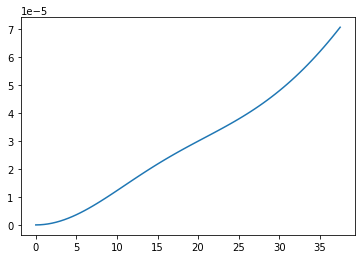

In [128]:
plt.plot(data["t_rec"][-1][-1],data["MSE"][-1][-1])

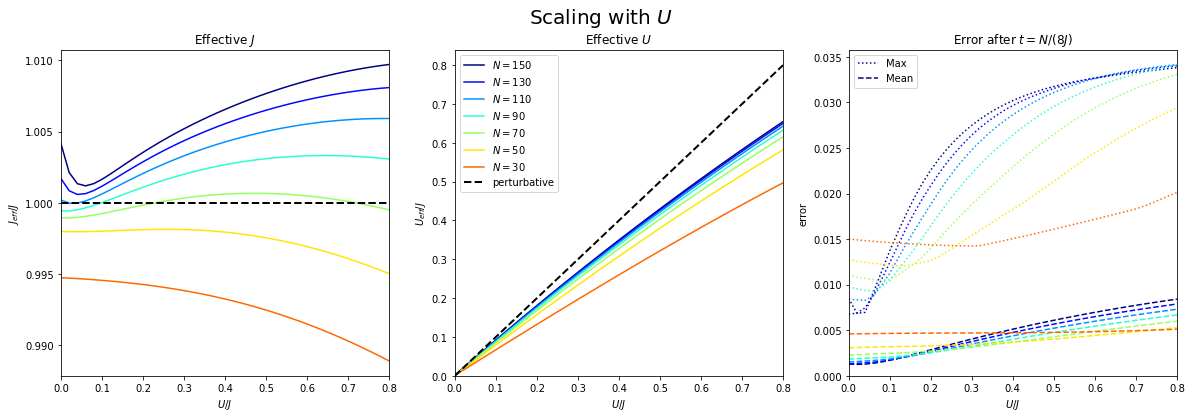

In [129]:
N_plot = list(range(30,151,20))

fig, ax = plt.subplots(1,3, figsize=(20,6))

# color code
clr = plt.cm.jet_r(data["v_N"]/np.max(data["v_N"])) 

# first panel
for N in np.flip(N_plot):
    i_N = np.argmin(np.abs(N-data["v_N"]))
    ax[0].plot(data["v_U"]/J, -data['J'][i_N,:]/J, color=clr[i_N], label=r"$N={}$".format(N))
    ax[0].set_ylabel(r"$J_{eff}/J$")
    ax[0].set_title(r"Effective $J$")
    
    ax[1].plot(data["v_U"]/J, data['U'][i_N,:]/J, color=clr[i_N], label=r"$N={}$".format(N))
    ax[1].set_ylabel(r"$U_{eff}/J$")
    ax[1].set_title(r"Effective $U$")
    
    ax[2].plot(data["v_U"]/J, np.sqrt(np.array(data['MSE'][i_N])[:,-1]), color=clr[i_N], linestyle="--", label=r"$N={}$".format(N))
    ax[2].plot(data["v_U"]/J, np.sqrt(np.array(data['Max_err'][i_N])[:,-1]), color=clr[i_N], linestyle=":", label=r"$N={}$".format(N))
    ax[2].set_ylabel("error")
    ax[2].set_title(r"Error after $t=N/(8J)$")

    
# perturbative results
ax[0].plot([np.min(data["v_U"])/J, np.max(data["v_U"])/J], [1.,1.], color="k", linewidth=2, linestyle="--", label="perturbative")
ax[1].plot(data["v_U"]/J, data["v_U"]/J, color="k", linewidth=2, linestyle="--", label="perturbative")

for a in ax:
    a.set_xlabel(r"$U/J$")
    a.set_xlim([np.min(data["v_U"])/J, np.max(data["v_U"])/J])

ax[1].set_ylim(bottom=0.)
ax[2].set_ylim(bottom=0.)
    
ax[1].legend()
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend([handles[1],handles[0]],["Max", "Mean"])

fig.suptitle(r'Scaling with $U$', fontsize=20)
plt.savefig("analysis_U_" + filename[1:] + ".pdf")

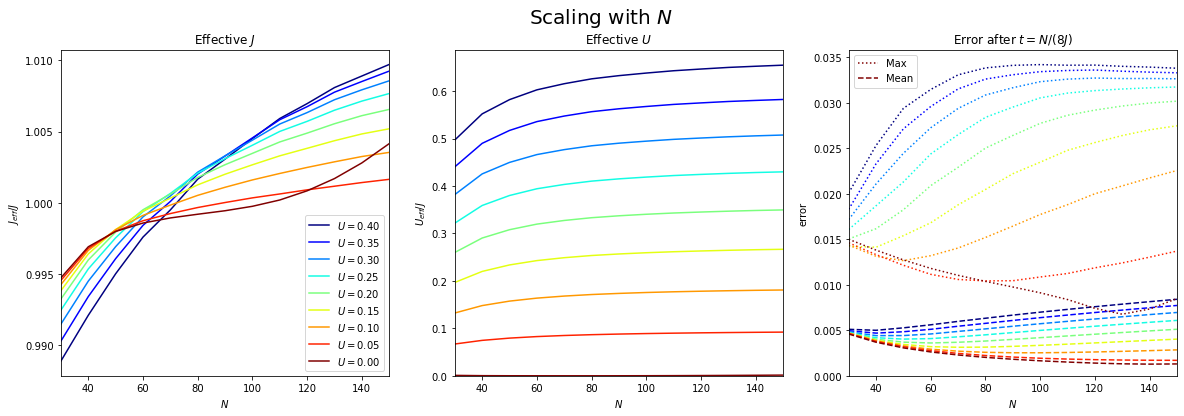

In [132]:
U_plot = list(np.arange(0.,.41,.05))
N_min = 30

fig, ax = plt.subplots(1,3, figsize=(20,6))

# color code
clr = plt.cm.jet_r(data["v_U"]/np.max(data["v_U"])) 

i_N_min = np.argmin(np.abs(N_min-data["v_N"]))

# first panel
for U in np.flip(U_plot):
    i_U = np.argmin(np.abs(U-data["v_U"]))
    ax[0].plot(data["v_N"][i_N_min:], -data['J'][i_N_min:,i_U].T/J, color=clr[i_U], label=r"$U={:.2f}$".format(U))
    ax[0].set_ylabel(r"$J_{eff}/J$")
    ax[0].set_title(r"Effective $J$")
    
    ax[1].plot(data["v_N"][i_N_min:], data['U'][i_N_min:,i_U].T/J, color=clr[i_U], label=r"$U={:.2f}$".format(U))
    ax[1].set_ylabel(r"$U_{eff}/J$")
    ax[1].set_title(r"Effective $U$")
    
    MSE_pl = [data['MSE'][i_N][i_U][-1] for i_N in range(i_N_min, len(data["v_N"]) )]
    Max_err_pl = [data['Max_err'][i_N][i_U][-1] for i_N in range(i_N_min, len(data["v_N"]) )]
    
    ax[2].plot(data["v_N"][i_N_min:], np.sqrt(MSE_pl), color=clr[i_U], linestyle="--", label=r"$U={}$".format(U))
    ax[2].plot(data["v_N"][i_N_min:], np.sqrt(Max_err_pl), color=clr[i_U], linestyle=":", label=r"$U={}$".format(U))
    ax[2].set_ylabel("error")
    ax[2].set_title(r"Error after $t=N/(8J)$")

    
# perturbative results
#ax[0].plot([np.min(data["v_U"]), np.max(data["v_U"])/J], [1.,1.], color="k", linewidth=2, linestyle="--", label="perturbative")
#ax[1].plot(data["v_U"]/J, data["v_U"]/J, color="k", linewidth=2, linestyle="--", label="perturbative")

for a in ax:
    a.set_xlabel(r"$N$")
    a.set_xlim([data["v_N"][i_N_min], data["v_N"][-1]])

ax[1].set_ylim(bottom=0.)
ax[2].set_ylim(bottom=0.)
    
ax[0].legend()
handles, labels = ax[2].get_legend_handles_labels()
ax[2].legend([handles[-1],handles[-2]],["Max", "Mean"])

fig.suptitle(r'Scaling with $N$', fontsize=20)
plt.savefig("analysis_N_" + filename[1:] + ".pdf")

60


utils/functions_regression.py:312: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_best = np.linalg.lstsq(X, TrainY)[0]
utils/functions_regression.py:348: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w[list(indexes)] = np.linalg.lstsq(TrainR[:, list(indexes)], TrainY)[0]


u_t = (-0.000038 -0.503482i)u_xx-u_yy
    + (-0.000018 +0.323272i)nx*u-ny*u
   
Time elapsed 0.43195199966430664


/opt/packages/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/packages/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/packages/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/packages/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


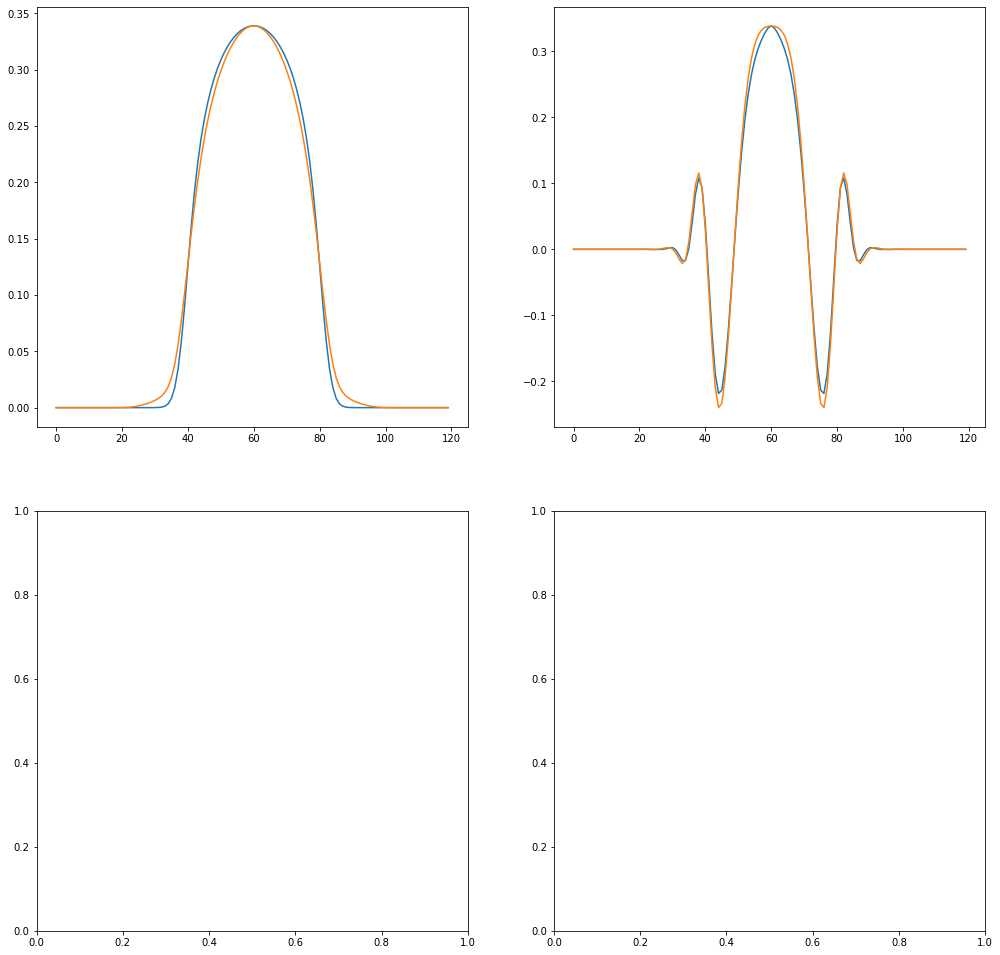

In [131]:
# check an instance
N = 120
U = 0.4
J = 0.5
V0 = -0.3

t_sat = 0.5

it_plot = -1

result = get_data(N, V0, U, J, nskip=10, return_full=True, t_frac=0.5)
n_true = np.array([result["g1"][it_plot,i,i] for i in range(N)])
n_rec = np.array([result["g1_rec"][it_plot,i,i] for i in range(N)])
g1_true = result["g1"][it_plot,N//2,:]
g1_rec = result["g1_rec"][it_plot,N//2,:]


fig, ax = plt.subplots(2,2 , figsize=(17,17))

ax[0,0].plot(n_true)
ax[0,0].plot(n_rec)

ax[0,1].plot(g1_true)
ax[0,1].plot(g1_rec)

In [5]:
# load list of data and obtain effective J's and U's with errors

v_N = np.arange(10,151,10)
v_U = concatenate(np.linspace(0.,.2,21)

V0 = -.3
J = .5

N_N = v_N.size
N_U = v_U.size

dat_J = np.zeros((N_N,N_U))
dat_U = np.zeros((N_N,N_U))
dat_err = np.zeros((N_N,N_U))

bar = progressbar.ProgressBar(maxval=N_N*N_U, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

count = 0
failed = []
for i_U, U in enumerate(list(v_U)):
    for i_N, N in enumerate(list(v_N)):
    
        filename = folder + "/data_N_{}_V0_{:.2f}_U_{:.2f}_J_{:.2f}_T_{:.2f}.pkl".format(N, V0, U, J, N/2.)
        
        t_slice=slice(0,-1)
        x_slice=slice(N//2-N//5,N//2+N//5+1)
        #x_slice = slice(None, None)
        
        try:
            u, t = get_data(filename)
            coefs, err = get_J_U_err_alt(u, t[1]-t[0], t_slice=t_slice, x_slice=x_slice)
        except:
            print(filename + " not found")
            coefs = [None, None]
            err = None
            failed.append( filename )
        
        dat_J[i_N,i_U] = coefs[0]
        dat_U[i_N,i_U] = coefs[1]
        dat_err[i_N,i_U] = err
        
        count += 1
        bar.update(count)
        
bar.finish()
        

u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0011472702026367188
u_t = (0.000017 -0.494249i)u_xx-u_yy
    + (-0.000011 +0.002107i)nx*u-ny*u
   
Time elapsed 0.0021390914916992188
u_t = (0.000005 -0.497376i)u_xx-u_yy
    + (0.000016 +0.000441i)nx*u-ny*u
   
Time elapsed 0.0047626495361328125
u_t = (0.000000 -0.498461i)u_xx-u_yy
    + (0.000004 +0.000142i)nx*u-ny*u
   
Time elapsed 0.014075994491577148
u_t = (0.000001 -0.498999i)u_xx-u_yy
    + (0.000001 +0.000051i)nx*u-ny*u
   
Time elapsed 0.026766300201416016
u_t = (0.000002 -0.499294i)u_xx-u_yy
    + (0.000000 +0.000029i)nx*u-ny*u
   
Time elapsed 0.06283116340637207
u_t = (-0.000001 -0.499473i)u_xx-u_yy
    + (0.000000 +0.000016i)nx*u-ny*u
   
Time elapsed 0.12966442108154297


u_t = (0.000001 -0.499602i)u_xx-u_yy
    + (-0.000000 +0.000017i)nx*u-ny*u
   
Time elapsed 0.17485427856445312
u_t = (0.000000 -0.499725i)u_xx-u_yy
    + (-0.000000 +0.000039i)nx*u-ny*u
   
Time elapsed 0.28826260566711426
u_t = (-0.000001 -0.499881i)u_xx-u_yy
    + (0.000000 +0.000087i)nx*u-ny*u
   
Time elapsed 0.32279467582702637
u_t = (-0.000001 -0.500102i)u_xx-u_yy
    + (0.000000 +0.000163i)nx*u-ny*u
   
Time elapsed 3.9776699542999268


u_t = (0.000001 -0.500424i)u_xx-u_yy
    + (-0.000000 +0.000272i)nx*u-ny*u
   
Time elapsed 0.6632668972015381
u_t = (0.000003 -0.500853i)u_xx-u_yy
    + (0.000000 +0.000405i)nx*u-ny*u
   
Time elapsed 0.9278378486633301
u_t = (-0.000006 -0.501402i)u_xx-u_yy
    + (-0.000000 +0.000556i)nx*u-ny*u
   
Time elapsed 1.2919437885284424


u_t = (0.000010 -0.502078i)u_xx-u_yy
    + (-0.000000 +0.000731i)nx*u-ny*u
   
Time elapsed 1.4289343357086182
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0009455680847167969
u_t = (0.000017 -0.494232i)u_xx-u_yy
    + (-0.000012 +0.007077i)nx*u-ny*u
   
Time elapsed 0.001912832260131836
u_t = (0.000005 -0.497361i)u_xx-u_yy
    + (0.000016 +0.007079i)nx*u-ny*u
   
Time elapsed 0.0057871341705322266
u_t = (0.000000 -0.498449i)u_xx-u_yy
    + (0.000004 +0.007616i)nx*u-ny*u
   
Time elapsed 0.01859760284423828


u_t = (0.000001 -0.498991i)u_xx-u_yy
    + (0.000001 +0.008029i)nx*u-ny*u
   
Time elapsed 0.02834177017211914
u_t = (0.000001 -0.499290i)u_xx-u_yy
    + (0.000000 +0.008341i)nx*u-ny*u
   
Time elapsed 0.05206108093261719
u_t = (-0.000002 -0.499474i)u_xx-u_yy
    + (0.000000 +0.008567i)nx*u-ny*u
   
Time elapsed 0.08393430709838867
u_t = (0.000001 -0.499606i)u_xx-u_yy
    + (-0.000001 +0.008744i)nx*u-ny*u
   
Time elapsed 0.14255833625793457


u_t = (0.000000 -0.499719i)u_xx-u_yy
    + (-0.000000 +0.008895i)nx*u-ny*u
   
Time elapsed 0.18373966217041016
u_t = (-0.000001 -0.499841i)u_xx-u_yy
    + (-0.000000 +0.009036i)nx*u-ny*u
   
Time elapsed 0.3322627544403076
u_t = (-0.000001 -0.499989i)u_xx-u_yy
    + (0.000000 +0.009173i)nx*u-ny*u
   
Time elapsed 0.5103325843811035
u_t = (0.000000 -0.500185i)u_xx-u_yy
    + (-0.000000 +0.009314i)nx*u-ny*u
   
Time elapsed 0.6897313594818115


u_t = (0.000002 -0.500426i)u_xx-u_yy
    + (0.000000 +0.009456i)nx*u-ny*u
   
Time elapsed 0.8072319030761719
u_t = (-0.000004 -0.500721i)u_xx-u_yy
    + (-0.000000 +0.009600i)nx*u-ny*u
   
Time elapsed 0.9069855213165283


u_t = (0.000004 -0.501067i)u_xx-u_yy
    + (-0.000000 +0.009748i)nx*u-ny*u
   
Time elapsed 1.1991674900054932
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0008985996246337891
u_t = (0.000017 -0.494212i)u_xx-u_yy
    + (-0.000012 +0.012040i)nx*u-ny*u
   
Time elapsed 0.0017473697662353516
u_t = (0.000006 -0.497345i)u_xx-u_yy
    + (0.000017 +0.013704i)nx*u-ny*u
   
Time elapsed 0.00576472282409668
u_t = (0.000001 -0.498438i)u_xx-u_yy
    + (0.000004 +0.015074i)nx*u-ny*u
   
Time elapsed 0.01285409927368164


u_t = (0.000001 -0.498989i)u_xx-u_yy
    + (0.000001 +0.015985i)nx*u-ny*u
   
Time elapsed 0.027293682098388672
u_t = (0.000001 -0.499299i)u_xx-u_yy
    + (-0.000000 +0.016629i)nx*u-ny*u
   
Time elapsed 0.04910635948181152
u_t = (-0.000003 -0.499493i)u_xx-u_yy
    + (0.000001 +0.017090i)nx*u-ny*u
   
Time elapsed 0.08402800559997559
u_t = (0.000000 -0.499638i)u_xx-u_yy
    + (-0.000001 +0.017442i)nx*u-ny*u
   
Time elapsed 0.1309525966644287
u_t = (0.000000 -0.499757i)u_xx-u_yy
    + (0.000000 +0.017723i)nx*u-ny*u
   
Time elapsed 0.19919538497924805


u_t = (-0.000003 -0.499875i)u_xx-u_yy
    + (-0.000001 +0.017961i)nx*u-ny*u
   
Time elapsed 0.28679656982421875
u_t = (-0.000001 -0.499995i)u_xx-u_yy
    + (0.000000 +0.018165i)nx*u-ny*u
   
Time elapsed 0.39964914321899414
u_t = (-0.000001 -0.500138i)u_xx-u_yy
    + (-0.000001 +0.018352i)nx*u-ny*u
   
Time elapsed 0.5461568832397461
u_t = (0.000002 -0.500297i)u_xx-u_yy
    + (0.000000 +0.018521i)nx*u-ny*u
   
Time elapsed 0.6970510482788086


u_t = (-0.000004 -0.500477i)u_xx-u_yy
    + (-0.000000 +0.018679i)nx*u-ny*u
   
Time elapsed 0.9482767581939697


u_t = (0.000001 -0.500674i)u_xx-u_yy
    + (-0.000000 +0.018825i)nx*u-ny*u
   
Time elapsed 1.3575115203857422
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.001041412353515625
u_t = (0.000017 -0.494189i)u_xx-u_yy
    + (-0.000013 +0.016995i)nx*u-ny*u
   
Time elapsed 0.0023365020751953125
u_t = (0.000006 -0.497327i)u_xx-u_yy
    + (0.000017 +0.020317i)nx*u-ny*u
   
Time elapsed 0.005718708038330078
u_t = (0.000001 -0.498427i)u_xx-u_yy
    + (0.000005 +0.022513i)nx*u-ny*u
   
Time elapsed 0.013376712799072266
u_t = (0.000001 -0.498992i)u_xx-u_yy
    + (-0.000000 +0.023920i)nx*u-ny*u
   
Time elapsed 0.029701709747314453
u_t = (0.000001 -0.499317i)u_xx-u_yy
    + (-0.000001 +0.024891i)nx*u-ny*u
   
Time elapsed 0.05298566818237305


u_t = (-0.000005 -0.499528i)u_xx-u_yy
    + (0.000002 +0.025584i)nx*u-ny*u
   
Time elapsed 0.10819554328918457
u_t = (-0.000000 -0.499692i)u_xx-u_yy
    + (-0.000001 +0.026108i)nx*u-ny*u
   
Time elapsed 0.17276382446289062
u_t = (0.000000 -0.499826i)u_xx-u_yy
    + (0.000000 +0.026515i)nx*u-ny*u
   
Time elapsed 0.2575078010559082
u_t = (-0.000007 -0.499953i)u_xx-u_yy
    + (-0.000001 +0.026853i)nx*u-ny*u
   
Time elapsed 0.37741637229919434


u_t = (-0.000001 -0.500068i)u_xx-u_yy
    + (0.000000 +0.027128i)nx*u-ny*u
   
Time elapsed 0.5157897472381592
u_t = (-0.000003 -0.500198i)u_xx-u_yy
    + (-0.000001 +0.027368i)nx*u-ny*u
   
Time elapsed 0.6605148315429688
u_t = (0.000003 -0.500325i)u_xx-u_yy
    + (0.000000 +0.027574i)nx*u-ny*u
   
Time elapsed 0.8179981708526611
u_t = (-0.000004 -0.500461i)u_xx-u_yy
    + (-0.000000 +0.027758i)nx*u-ny*u
   
Time elapsed 1.0368163585662842


u_t = (0.000000 -0.500598i)u_xx-u_yy
    + (-0.000000 +0.027918i)nx*u-ny*u
   
Time elapsed 1.2722594738006592
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0008306503295898438
u_t = (0.000017 -0.494162i)u_xx-u_yy
    + (-0.000013 +0.021941i)nx*u-ny*u
   
Time elapsed 0.0017910003662109375
u_t = (0.000006 -0.497306i)u_xx-u_yy
    + (0.000017 +0.026916i)nx*u-ny*u
   
Time elapsed 0.0054929256439208984
u_t = (0.000002 -0.498416i)u_xx-u_yy
    + (0.000006 +0.029933i)nx*u-ny*u
   
Time elapsed 0.013035297393798828
u_t = (0.000001 -0.498999i)u_xx-u_yy
    + (-0.000001 +0.031830i)nx*u-ny*u
   
Time elapsed 0.02460765838623047
u_t = (-0.000000 -0.499343i)u_xx-u_yy
    + (-0.000001 +0.033126i)nx*u-ny*u
   
Time elapsed 0.04941821098327637
u_t = (-0.000008 -0.499573i)u_xx-u_yy
    + (0.000003 +0.034045i)nx*u-ny*u
   
Time elapsed 0.08157944679260254


u_t = (-0.000001 -0.499760i)u_xx-u_yy
    + (-0.000002 +0.034738i)nx*u-ny*u
   
Time elapsed 0.1329662799835205
u_t = (0.000000 -0.499914i)u_xx-u_yy
    + (0.000000 +0.035269i)nx*u-ny*u
   
Time elapsed 0.20326447486877441
u_t = (-0.000010 -0.500057i)u_xx-u_yy
    + (-0.000002 +0.035705i)nx*u-ny*u
   
Time elapsed 0.27547121047973633
u_t = (-0.000001 -0.500180i)u_xx-u_yy
    + (0.000001 +0.036052i)nx*u-ny*u
   
Time elapsed 0.4231076240539551


u_t = (-0.000005 -0.500314i)u_xx-u_yy
    + (-0.000002 +0.036348i)nx*u-ny*u
   
Time elapsed 0.6983814239501953
u_t = (0.000003 -0.500435i)u_xx-u_yy
    + (0.000001 +0.036597i)nx*u-ny*u
   
Time elapsed 0.8832628726959229
u_t = (-0.000003 -0.500560i)u_xx-u_yy
    + (-0.000001 +0.036814i)nx*u-ny*u
   
Time elapsed 1.1827025413513184


u_t = (-0.000000 -0.500676i)u_xx-u_yy
    + (-0.000000 +0.036997i)nx*u-ny*u
   
Time elapsed 1.5700514316558838
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0010225772857666016
u_t = (0.000017 -0.494133i)u_xx-u_yy
    + (-0.000014 +0.026879i)nx*u-ny*u
   
Time elapsed 0.002568960189819336
u_t = (0.000007 -0.497284i)u_xx-u_yy
    + (0.000018 +0.033501i)nx*u-ny*u
   
Time elapsed 0.006357431411743164
u_t = (0.000003 -0.498405i)u_xx-u_yy
    + (0.000007 +0.037334i)nx*u-ny*u
   
Time elapsed 0.014506816864013672


u_t = (0.000002 -0.499008i)u_xx-u_yy
    + (-0.000002 +0.039716i)nx*u-ny*u
   
Time elapsed 0.03160858154296875
u_t = (-0.000002 -0.499375i)u_xx-u_yy
    + (-0.000002 +0.041331i)nx*u-ny*u
   
Time elapsed 0.0590977668762207
u_t = (-0.000012 -0.499626i)u_xx-u_yy
    + (0.000004 +0.042472i)nx*u-ny*u
   
Time elapsed 0.11070442199707031
u_t = (-0.000002 -0.499838i)u_xx-u_yy
    + (-0.000002 +0.043331i)nx*u-ny*u
   
Time elapsed 0.17216849327087402


u_t = (0.000000 -0.500013i)u_xx-u_yy
    + (0.000000 +0.043981i)nx*u-ny*u
   
Time elapsed 0.2720375061035156
u_t = (-0.000015 -0.500176i)u_xx-u_yy
    + (-0.000003 +0.044512i)nx*u-ny*u
   
Time elapsed 0.3871009349822998
u_t = (-0.000001 -0.500313i)u_xx-u_yy
    + (0.000001 +0.044930i)nx*u-ny*u
   
Time elapsed 0.6022634506225586
u_t = (-0.000007 -0.500458i)u_xx-u_yy
    + (-0.000003 +0.045283i)nx*u-ny*u
   
Time elapsed 0.6203734874725342


u_t = (0.000003 -0.500585i)u_xx-u_yy
    + (0.000001 +0.045576i)nx*u-ny*u
   
Time elapsed 1.0047099590301514
u_t = (-0.000003 -0.500713i)u_xx-u_yy
    + (-0.000002 +0.045830i)nx*u-ny*u
   
Time elapsed 1.445082187652588


u_t = (-0.000000 -0.500826i)u_xx-u_yy
    + (-0.000001 +0.046038i)nx*u-ny*u
   
Time elapsed 1.825303077697754
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0012867450714111328
u_t = (0.000017 -0.494100i)u_xx-u_yy
    + (-0.000014 +0.031808i)nx*u-ny*u
   
Time elapsed 0.0019404888153076172
u_t = (0.000007 -0.497259i)u_xx-u_yy
    + (0.000018 +0.040071i)nx*u-ny*u
   
Time elapsed 0.006973981857299805
u_t = (0.000004 -0.498393i)u_xx-u_yy
    + (0.000008 +0.044713i)nx*u-ny*u
   
Time elapsed 0.017319917678833008


u_t = (0.000002 -0.499019i)u_xx-u_yy
    + (-0.000003 +0.047574i)nx*u-ny*u
   
Time elapsed 0.03825736045837402
u_t = (-0.000003 -0.499410i)u_xx-u_yy
    + (-0.000002 +0.049505i)nx*u-ny*u
   
Time elapsed 0.07386422157287598
u_t = (-0.000016 -0.499683i)u_xx-u_yy
    + (0.000006 +0.050862i)nx*u-ny*u
   
Time elapsed 0.12886714935302734
u_t = (-0.000002 -0.499921i)u_xx-u_yy
    + (-0.000003 +0.051882i)nx*u-ny*u
   
Time elapsed 0.21258878707885742
u_t = (0.000000 -0.500119i)u_xx-u_yy
    + (0.000000 +0.052647i)nx*u-ny*u
   
Time elapsed 0.31465768814086914


u_t = (-0.000019 -0.500303i)u_xx-u_yy
    + (-0.000003 +0.053272i)nx*u-ny*u
   
Time elapsed 0.4794001579284668
u_t = (-0.000001 -0.500456i)u_xx-u_yy
    + (0.000002 +0.053759i)nx*u-ny*u
   
Time elapsed 0.5815324783325195
u_t = (-0.000009 -0.500615i)u_xx-u_yy
    + (-0.000004 +0.054167i)nx*u-ny*u
   
Time elapsed 0.7244088649749756
u_t = (0.000002 -0.500753i)u_xx-u_yy
    + (0.000001 +0.054504i)nx*u-ny*u
   
Time elapsed 0.893068790435791


u_t = (-0.000002 -0.500891i)u_xx-u_yy
    + (-0.000003 +0.054796i)nx*u-ny*u
   
Time elapsed 1.1369304656982422


u_t = (0.000000 -0.501008i)u_xx-u_yy
    + (-0.000001 +0.055031i)nx*u-ny*u
   
Time elapsed 1.5311543941497803
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0010061264038085938
u_t = (0.000017 -0.494064i)u_xx-u_yy
    + (-0.000014 +0.036727i)nx*u-ny*u
   
Time elapsed 0.0018649101257324219
u_t = (0.000008 -0.497232i)u_xx-u_yy
    + (0.000019 +0.046626i)nx*u-ny*u
   
Time elapsed 0.00653839111328125
u_t = (0.000005 -0.498381i)u_xx-u_yy
    + (0.000009 +0.052070i)nx*u-ny*u
   
Time elapsed 0.015298604965209961
u_t = (0.000003 -0.499030i)u_xx-u_yy
    + (-0.000004 +0.055403i)nx*u-ny*u
   
Time elapsed 0.03380537033081055
u_t = (-0.000005 -0.499448i)u_xx-u_yy
    + (-0.000003 +0.057646i)nx*u-ny*u
   
Time elapsed 0.060388803482055664


u_t = (-0.000021 -0.499743i)u_xx-u_yy
    + (0.000007 +0.059214i)nx*u-ny*u
   
Time elapsed 0.11209440231323242
u_t = (-0.000002 -0.500007i)u_xx-u_yy
    + (-0.000003 +0.060392i)nx*u-ny*u
   
Time elapsed 0.15757989883422852
u_t = (0.000001 -0.500228i)u_xx-u_yy
    + (0.000000 +0.061266i)nx*u-ny*u
   
Time elapsed 0.2376708984375
u_t = (-0.000023 -0.500432i)u_xx-u_yy
    + (-0.000004 +0.061980i)nx*u-ny*u
   
Time elapsed 0.3493058681488037


u_t = (-0.000000 -0.500603i)u_xx-u_yy
    + (0.000002 +0.062535i)nx*u-ny*u
   
Time elapsed 0.4558110237121582
u_t = (-0.000011 -0.500776i)u_xx-u_yy
    + (-0.000004 +0.062996i)nx*u-ny*u
   
Time elapsed 0.6213598251342773
u_t = (0.000001 -0.500928i)u_xx-u_yy
    + (0.000002 +0.063377i)nx*u-ny*u
   
Time elapsed 0.777268648147583
u_t = (-0.000000 -0.501078i)u_xx-u_yy
    + (-0.000004 +0.063707i)nx*u-ny*u
   
Time elapsed 1.0472354888916016


u_t = (0.000000 -0.501201i)u_xx-u_yy
    + (-0.000001 +0.063968i)nx*u-ny*u
   
Time elapsed 1.384284496307373
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.000850677490234375
u_t = (0.000018 -0.494026i)u_xx-u_yy
    + (-0.000014 +0.041636i)nx*u-ny*u
   
Time elapsed 0.0018739700317382812
u_t = (0.000008 -0.497203i)u_xx-u_yy
    + (0.000019 +0.053163i)nx*u-ny*u
   
Time elapsed 0.00642704963684082
u_t = (0.000006 -0.498367i)u_xx-u_yy
    + (0.000010 +0.059404i)nx*u-ny*u
   
Time elapsed 0.014909744262695312
u_t = (0.000004 -0.499042i)u_xx-u_yy
    + (-0.000006 +0.063202i)nx*u-ny*u
   
Time elapsed 0.029550552368164062
u_t = (-0.000008 -0.499486i)u_xx-u_yy
    + (-0.000004 +0.065752i)nx*u-ny*u
   
Time elapsed 0.05431556701660156
u_t = (-0.000026 -0.499804i)u_xx-u_yy
    + (0.000009 +0.067525i)nx*u-ny*u
   
Time elapsed 0.09397125244140625


u_t = (-0.000002 -0.500094i)u_xx-u_yy
    + (-0.000004 +0.068856i)nx*u-ny*u
   
Time elapsed 0.14647173881530762
u_t = (0.000001 -0.500336i)u_xx-u_yy
    + (0.000000 +0.069836i)nx*u-ny*u
   
Time elapsed 0.23328542709350586
u_t = (-0.000027 -0.500560i)u_xx-u_yy
    + (-0.000005 +0.070636i)nx*u-ny*u
   
Time elapsed 0.2858085632324219
u_t = (0.000000 -0.500749i)u_xx-u_yy
    + (0.000003 +0.071257i)nx*u-ny*u
   
Time elapsed 0.42968034744262695


u_t = (-0.000013 -0.500936i)u_xx-u_yy
    + (-0.000005 +0.071768i)nx*u-ny*u
   
Time elapsed 0.580003023147583
u_t = (-0.000000 -0.501103i)u_xx-u_yy
    + (0.000002 +0.072192i)nx*u-ny*u
   
Time elapsed 0.6840324401855469
u_t = (0.000001 -0.501265i)u_xx-u_yy
    + (-0.000006 +0.072559i)nx*u-ny*u
   
Time elapsed 1.0351014137268066


u_t = (0.000001 -0.501396i)u_xx-u_yy
    + (-0.000001 +0.072847i)nx*u-ny*u
   
Time elapsed 1.3675320148468018
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0012638568878173828
u_t = (0.000019 -0.493984i)u_xx-u_yy
    + (-0.000014 +0.046535i)nx*u-ny*u
   
Time elapsed 0.001954793930053711
u_t = (0.000009 -0.497171i)u_xx-u_yy
    + (0.000019 +0.059683i)nx*u-ny*u
   
Time elapsed 0.006174564361572266
u_t = (0.000007 -0.498352i)u_xx-u_yy
    + (0.000012 +0.066713i)nx*u-ny*u
   
Time elapsed 0.014662981033325195
u_t = (0.000006 -0.499052i)u_xx-u_yy
    + (-0.000007 +0.070970i)nx*u-ny*u
   
Time elapsed 0.028774023056030273
u_t = (-0.000011 -0.499525i)u_xx-u_yy
    + (-0.000004 +0.073821i)nx*u-ny*u
   
Time elapsed 0.050699472427368164
u_t = (-0.000031 -0.499864i)u_xx-u_yy
    + (0.000011 +0.075794i)nx*u-ny*u
   
Time elapsed 0.0745396614074707
u_t = (-0.000002 -0.500180i)u_xx-u_yy
    + (-0.000004 +0.077275i)nx*u-ny*u
   
Time elapsed 0.13994

u_t = (0.000002 -0.500444i)u_xx-u_yy
    + (0.000000 +0.078356i)nx*u-ny*u
   
Time elapsed 0.2384932041168213
u_t = (-0.000031 -0.500685i)u_xx-u_yy
    + (-0.000005 +0.079238i)nx*u-ny*u
   
Time elapsed 0.33244943618774414
u_t = (0.000001 -0.500893i)u_xx-u_yy
    + (0.000003 +0.079923i)nx*u-ny*u
   
Time elapsed 0.4609720706939697
u_t = (-0.000015 -0.501092i)u_xx-u_yy
    + (-0.000005 +0.080482i)nx*u-ny*u
   
Time elapsed 0.6098310947418213


u_t = (-0.000002 -0.501274i)u_xx-u_yy
    + (0.000002 +0.080949i)nx*u-ny*u
   
Time elapsed 0.7862720489501953
u_t = (0.000002 -0.501448i)u_xx-u_yy
    + (-0.000007 +0.081352i)nx*u-ny*u
   
Time elapsed 1.098304271697998


u_t = (0.000001 -0.501587i)u_xx-u_yy
    + (-0.000001 +0.081665i)nx*u-ny*u
   
Time elapsed 1.4013197422027588
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0009055137634277344
u_t = (0.000019 -0.493940i)u_xx-u_yy
    + (-0.000014 +0.051422i)nx*u-ny*u
   
Time elapsed 0.0018794536590576172
u_t = (0.000009 -0.497137i)u_xx-u_yy
    + (0.000020 +0.066185i)nx*u-ny*u
   
Time elapsed 0.005632638931274414
u_t = (0.000009 -0.498335i)u_xx-u_yy
    + (0.000013 +0.073997i)nx*u-ny*u
   
Time elapsed 0.015540122985839844
u_t = (0.000008 -0.499061i)u_xx-u_yy
    + (-0.000009 +0.078704i)nx*u-ny*u
   
Time elapsed 0.029620647430419922


u_t = (-0.000014 -0.499562i)u_xx-u_yy
    + (-0.000005 +0.081853i)nx*u-ny*u
   
Time elapsed 0.05395793914794922
u_t = (-0.000036 -0.499923i)u_xx-u_yy
    + (0.000013 +0.084020i)nx*u-ny*u
   
Time elapsed 0.0931088924407959
u_t = (-0.000002 -0.500265i)u_xx-u_yy
    + (-0.000004 +0.085646i)nx*u-ny*u
   
Time elapsed 0.1532294750213623
u_t = (0.000004 -0.500548i)u_xx-u_yy
    + (0.000000 +0.086825i)nx*u-ny*u
   
Time elapsed 0.23158478736877441


u_t = (-0.000034 -0.500806i)u_xx-u_yy
    + (-0.000006 +0.087785i)nx*u-ny*u
   
Time elapsed 0.32522130012512207
u_t = (0.000002 -0.501032i)u_xx-u_yy
    + (0.000004 +0.088532i)nx*u-ny*u
   
Time elapsed 0.4545257091522217
u_t = (-0.000017 -0.501244i)u_xx-u_yy
    + (-0.000005 +0.089139i)nx*u-ny*u
   
Time elapsed 0.5953130722045898
u_t = (-0.000004 -0.501441i)u_xx-u_yy
    + (0.000003 +0.089646i)nx*u-ny*u
   
Time elapsed 0.7611644268035889


u_t = (0.000003 -0.501626i)u_xx-u_yy
    + (-0.000009 +0.090085i)nx*u-ny*u
   
Time elapsed 1.0381059646606445


u_t = (0.000001 -0.501772i)u_xx-u_yy
    + (-0.000001 +0.090422i)nx*u-ny*u
   
Time elapsed 1.3557448387145996
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0010075569152832031
u_t = (0.000020 -0.493893i)u_xx-u_yy
    + (-0.000014 +0.056298i)nx*u-ny*u
   
Time elapsed 0.0022962093353271484
u_t = (0.000010 -0.497100i)u_xx-u_yy
    + (0.000020 +0.072667i)nx*u-ny*u
   
Time elapsed 0.0051915645599365234
u_t = (0.000010 -0.498315i)u_xx-u_yy
    + (0.000015 +0.081254i)nx*u-ny*u
   
Time elapsed 0.013528585433959961
u_t = (0.000010 -0.499068i)u_xx-u_yy
    + (-0.000010 +0.086403i)nx*u-ny*u
   
Time elapsed 0.02866673469543457
u_t = (-0.000017 -0.499598i)u_xx-u_yy
    + (-0.000006 +0.089846i)nx*u-ny*u
   
Time elapsed 0.05239224433898926


u_t = (-0.000041 -0.499979i)u_xx-u_yy
    + (0.000015 +0.092201i)nx*u-ny*u
   
Time elapsed 0.09659838676452637
u_t = (-0.000002 -0.500346i)u_xx-u_yy
    + (-0.000005 +0.093968i)nx*u-ny*u
   
Time elapsed 0.15411639213562012
u_t = (0.000006 -0.500649i)u_xx-u_yy
    + (-0.000000 +0.095242i)nx*u-ny*u
   
Time elapsed 0.22146153450012207
u_t = (-0.000038 -0.500923i)u_xx-u_yy
    + (-0.000007 +0.096277i)nx*u-ny*u
   
Time elapsed 0.32659912109375


u_t = (0.000002 -0.501167i)u_xx-u_yy
    + (0.000004 +0.097085i)nx*u-ny*u
   
Time elapsed 0.4457814693450928
u_t = (-0.000019 -0.501390i)u_xx-u_yy
    + (-0.000006 +0.097737i)nx*u-ny*u
   
Time elapsed 0.5941908359527588
u_t = (-0.000005 -0.501601i)u_xx-u_yy
    + (0.000003 +0.098285i)nx*u-ny*u
   
Time elapsed 0.7250833511352539
u_t = (0.000003 -0.501798i)u_xx-u_yy
    + (-0.000010 +0.098759i)nx*u-ny*u
   
Time elapsed 1.0019547939300537


u_t = (0.000002 -0.501951i)u_xx-u_yy
    + (-0.000001 +0.099119i)nx*u-ny*u
   
Time elapsed 1.362670660018921
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0009717941284179688
u_t = (0.000021 -0.493842i)u_xx-u_yy
    + (-0.000014 +0.061162i)nx*u-ny*u
   
Time elapsed 0.0022814273834228516
u_t = (0.000010 -0.497061i)u_xx-u_yy
    + (0.000021 +0.079128i)nx*u-ny*u
   
Time elapsed 0.005450248718261719
u_t = (0.000011 -0.498293i)u_xx-u_yy
    + (0.000016 +0.088483i)nx*u-ny*u
   
Time elapsed 0.014985084533691406
u_t = (0.000012 -0.499072i)u_xx-u_yy
    + (-0.000012 +0.094067i)nx*u-ny*u
   
Time elapsed 0.03578591346740723
u_t = (-0.000021 -0.499631i)u_xx-u_yy
    + (-0.000006 +0.097799i)nx*u-ny*u
   
Time elapsed 0.06093478202819824
u_t = (-0.000046 -0.500032i)u_xx-u_yy
    + (0.000017 +0.100337i)nx*u-ny*u
   
Time elapsed 0.1161801815032959


u_t = (-0.000001 -0.500424i)u_xx-u_yy
    + (-0.000005 +0.102242i)nx*u-ny*u
   
Time elapsed 0.16041898727416992
u_t = (0.000008 -0.500745i)u_xx-u_yy
    + (-0.000000 +0.103607i)nx*u-ny*u
   
Time elapsed 0.2777559757232666
u_t = (-0.000041 -0.501034i)u_xx-u_yy
    + (-0.000007 +0.104714i)nx*u-ny*u
   
Time elapsed 0.3974161148071289
u_t = (0.000004 -0.501296i)u_xx-u_yy
    + (0.000005 +0.105582i)nx*u-ny*u
   
Time elapsed 0.5667500495910645


u_t = (-0.000020 -0.501530i)u_xx-u_yy
    + (-0.000006 +0.106277i)nx*u-ny*u
   
Time elapsed 0.7564761638641357
u_t = (-0.000007 -0.501756i)u_xx-u_yy
    + (0.000003 +0.106865i)nx*u-ny*u
   
Time elapsed 0.9368422031402588
u_t = (0.000004 -0.501963i)u_xx-u_yy
    + (-0.000012 +0.107372i)nx*u-ny*u
   
Time elapsed 1.2233269214630127


u_t = (0.000002 -0.502123i)u_xx-u_yy
    + (-0.000001 +0.107756i)nx*u-ny*u
   
Time elapsed 1.6580007076263428
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0010929107666015625
u_t = (0.000022 -0.493789i)u_xx-u_yy
    + (-0.000014 +0.066014i)nx*u-ny*u
   
Time elapsed 0.002387523651123047
u_t = (0.000011 -0.497018i)u_xx-u_yy
    + (0.000021 +0.085569i)nx*u-ny*u
   
Time elapsed 0.0068356990814208984


u_t = (0.000013 -0.498269i)u_xx-u_yy
    + (0.000018 +0.095684i)nx*u-ny*u
   
Time elapsed 0.015110492706298828
u_t = (0.000015 -0.499073i)u_xx-u_yy
    + (-0.000014 +0.101693i)nx*u-ny*u
   
Time elapsed 0.03511786460876465
u_t = (-0.000024 -0.499661i)u_xx-u_yy
    + (-0.000006 +0.105709i)nx*u-ny*u
   
Time elapsed 0.0661616325378418
u_t = (-0.000051 -0.500082i)u_xx-u_yy
    + (0.000018 +0.108426i)nx*u-ny*u
   
Time elapsed 0.11523032188415527
u_t = (-0.000001 -0.500498i)u_xx-u_yy
    + (-0.000005 +0.110465i)nx*u-ny*u
   
Time elapsed 0.17977190017700195


u_t = (0.000010 -0.500837i)u_xx-u_yy
    + (-0.000001 +0.111919i)nx*u-ny*u
   
Time elapsed 0.2722201347351074
u_t = (-0.000044 -0.501140i)u_xx-u_yy
    + (-0.000008 +0.113095i)nx*u-ny*u
   
Time elapsed 0.40259242057800293
u_t = (0.000005 -0.501420i)u_xx-u_yy
    + (0.000005 +0.114022i)nx*u-ny*u
   
Time elapsed 0.5564422607421875
u_t = (-0.000021 -0.501664i)u_xx-u_yy
    + (-0.000007 +0.114760i)nx*u-ny*u
   
Time elapsed 0.7163290977478027


u_t = (-0.000008 -0.501904i)u_xx-u_yy
    + (0.000004 +0.115388i)nx*u-ny*u
   
Time elapsed 0.9102420806884766
u_t = (0.000004 -0.502121i)u_xx-u_yy
    + (-0.000013 +0.115928i)nx*u-ny*u
   
Time elapsed 1.1989378929138184


u_t = (0.000002 -0.502288i)u_xx-u_yy
    + (-0.000001 +0.116335i)nx*u-ny*u
   
Time elapsed 1.4955217838287354
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0008597373962402344
u_t = (0.000023 -0.493733i)u_xx-u_yy
    + (-0.000014 +0.070852i)nx*u-ny*u
   
Time elapsed 0.0023403167724609375
u_t = (0.000012 -0.496973i)u_xx-u_yy
    + (0.000021 +0.091988i)nx*u-ny*u
   
Time elapsed 0.008129596710205078
u_t = (0.000014 -0.498241i)u_xx-u_yy
    + (0.000020 +0.102854i)nx*u-ny*u
   
Time elapsed 0.013205528259277344


u_t = (0.000018 -0.499070i)u_xx-u_yy
    + (-0.000016 +0.109282i)nx*u-ny*u
   
Time elapsed 0.03315329551696777
u_t = (-0.000028 -0.499687i)u_xx-u_yy
    + (-0.000007 +0.113578i)nx*u-ny*u
   
Time elapsed 0.06041836738586426
u_t = (-0.000055 -0.500128i)u_xx-u_yy
    + (0.000020 +0.116468i)nx*u-ny*u
   
Time elapsed 0.07704901695251465
u_t = (-0.000000 -0.500567i)u_xx-u_yy
    + (-0.000005 +0.118638i)nx*u-ny*u
   
Time elapsed 0.16569733619689941
u_t = (0.000013 -0.500924i)u_xx-u_yy
    + (-0.000001 +0.120179i)nx*u-ny*u
   
Time elapsed 0.26692938804626465


u_t = (-0.000047 -0.501241i)u_xx-u_yy
    + (-0.000009 +0.121421i)nx*u-ny*u
   
Time elapsed 0.3852884769439697
u_t = (0.000006 -0.501538i)u_xx-u_yy
    + (0.000005 +0.122406i)nx*u-ny*u
   
Time elapsed 0.5455536842346191
u_t = (-0.000023 -0.501792i)u_xx-u_yy
    + (-0.000007 +0.123186i)nx*u-ny*u
   
Time elapsed 0.704585075378418
u_t = (-0.000009 -0.502045i)u_xx-u_yy
    + (0.000004 +0.123853i)nx*u-ny*u
   
Time elapsed 0.8992283344268799


u_t = (0.000004 -0.502273i)u_xx-u_yy
    + (-0.000015 +0.124425i)nx*u-ny*u
   
Time elapsed 1.1342954635620117


u_t = (0.000003 -0.502447i)u_xx-u_yy
    + (-0.000002 +0.124855i)nx*u-ny*u
   
Time elapsed 1.6090881824493408
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.001148223876953125
u_t = (0.000024 -0.493674i)u_xx-u_yy
    + (-0.000014 +0.075677i)nx*u-ny*u
   
Time elapsed 0.0025184154510498047
u_t = (0.000012 -0.496924i)u_xx-u_yy
    + (0.000021 +0.098383i)nx*u-ny*u
   
Time elapsed 0.006604433059692383
u_t = (0.000015 -0.498210i)u_xx-u_yy
    + (0.000021 +0.109993i)nx*u-ny*u
   
Time elapsed 0.018950223922729492
u_t = (0.000021 -0.499065i)u_xx-u_yy
    + (-0.000018 +0.116831i)nx*u-ny*u
   
Time elapsed 0.032137393951416016
u_t = (-0.000033 -0.499710i)u_xx-u_yy
    + (-0.000007 +0.121402i)nx*u-ny*u
   
Time elapsed 0.06534457206726074


u_t = (-0.000059 -0.500169i)u_xx-u_yy
    + (0.000022 +0.124462i)nx*u-ny*u
   
Time elapsed 0.10187220573425293
u_t = (0.000000 -0.500633i)u_xx-u_yy
    + (-0.000005 +0.126760i)nx*u-ny*u
   
Time elapsed 0.17042946815490723
u_t = (0.000016 -0.501006i)u_xx-u_yy
    + (-0.000002 +0.128385i)nx*u-ny*u
   
Time elapsed 0.26616835594177246
u_t = (-0.000050 -0.501336i)u_xx-u_yy
    + (-0.000010 +0.129691i)nx*u-ny*u
   
Time elapsed 0.35681939125061035


u_t = (0.000007 -0.501651i)u_xx-u_yy
    + (0.000005 +0.130735i)nx*u-ny*u
   
Time elapsed 0.5055530071258545
u_t = (-0.000024 -0.501915i)u_xx-u_yy
    + (-0.000007 +0.131556i)nx*u-ny*u
   
Time elapsed 0.5734093189239502
u_t = (-0.000010 -0.502181i)u_xx-u_yy
    + (0.000004 +0.132261i)nx*u-ny*u
   
Time elapsed 0.7731225490570068
u_t = (0.000004 -0.502419i)u_xx-u_yy
    + (-0.000016 +0.132864i)nx*u-ny*u
   
Time elapsed 1.062016248703003


u_t = (0.000004 -0.502600i)u_xx-u_yy
    + (-0.000002 +0.133318i)nx*u-ny*u
   
Time elapsed 1.4040098190307617
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0012614727020263672
u_t = (0.000025 -0.493612i)u_xx-u_yy
    + (-0.000015 +0.080488i)nx*u-ny*u
   
Time elapsed 0.0019485950469970703
u_t = (0.000013 -0.496872i)u_xx-u_yy
    + (0.000022 +0.104755i)nx*u-ny*u
   
Time elapsed 0.005757331848144531
u_t = (0.000017 -0.498175i)u_xx-u_yy
    + (0.000023 +0.117101i)nx*u-ny*u
   
Time elapsed 0.01499032974243164
u_t = (0.000025 -0.499055i)u_xx-u_yy
    + (-0.000020 +0.124340i)nx*u-ny*u
   
Time elapsed 0.0288236141204834
u_t = (-0.000037 -0.499729i)u_xx-u_yy
    + (-0.000007 +0.129183i)nx*u-ny*u
   
Time elapsed 0.05263543128967285
u_t = (-0.000063 -0.500206i)u_xx-u_yy
    + (0.000023 +0.132407i)nx*u-ny*u
   
Time elapsed 0.07582664489746094


u_t = (0.000001 -0.500694i)u_xx-u_yy
    + (-0.000005 +0.134831i)nx*u-ny*u
   
Time elapsed 0.13780689239501953
u_t = (0.000018 -0.501083i)u_xx-u_yy
    + (-0.000002 +0.136539i)nx*u-ny*u
   
Time elapsed 0.18776321411132812
u_t = (-0.000053 -0.501427i)u_xx-u_yy
    + (-0.000010 +0.137907i)nx*u-ny*u
   
Time elapsed 0.2682833671569824
u_t = (0.000009 -0.501758i)u_xx-u_yy
    + (0.000005 +0.139008i)nx*u-ny*u
   
Time elapsed 0.3717176914215088


u_t = (-0.000026 -0.502032i)u_xx-u_yy
    + (-0.000008 +0.139870i)nx*u-ny*u
   
Time elapsed 0.5356671810150146
u_t = (-0.000011 -0.502311i)u_xx-u_yy
    + (0.000004 +0.140612i)nx*u-ny*u
   
Time elapsed 0.6251277923583984
u_t = (0.000004 -0.502558i)u_xx-u_yy
    + (-0.000017 +0.141247i)nx*u-ny*u
   
Time elapsed 0.8418400287628174


u_t = (0.000004 -0.502746i)u_xx-u_yy
    + (-0.000002 +0.141724i)nx*u-ny*u
   
Time elapsed 1.222109317779541
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0008578300476074219
u_t = (0.000026 -0.493547i)u_xx-u_yy
    + (-0.000015 +0.085284i)nx*u-ny*u
   
Time elapsed 0.0018165111541748047
u_t = (0.000014 -0.496817i)u_xx-u_yy
    + (0.000022 +0.111103i)nx*u-ny*u
   
Time elapsed 0.004868030548095703
u_t = (0.000018 -0.498137i)u_xx-u_yy
    + (0.000025 +0.124175i)nx*u-ny*u
   
Time elapsed 0.012170553207397461


u_t = (0.000029 -0.499041i)u_xx-u_yy
    + (-0.000022 +0.131808i)nx*u-ny*u
   
Time elapsed 0.026726961135864258
u_t = (-0.000041 -0.499743i)u_xx-u_yy
    + (-0.000007 +0.136918i)nx*u-ny*u
   
Time elapsed 0.04875326156616211
u_t = (-0.000067 -0.500239i)u_xx-u_yy
    + (0.000024 +0.140303i)nx*u-ny*u
   
Time elapsed 0.07694339752197266
u_t = (0.000002 -0.500750i)u_xx-u_yy
    + (-0.000005 +0.142851i)nx*u-ny*u
   
Time elapsed 0.12684869766235352


u_t = (0.000021 -0.501154i)u_xx-u_yy
    + (-0.000003 +0.144639i)nx*u-ny*u
   
Time elapsed 0.27295851707458496
u_t = (-0.000056 -0.501512i)u_xx-u_yy
    + (-0.000011 +0.146067i)nx*u-ny*u
   
Time elapsed 0.4486238956451416
u_t = (0.000011 -0.501861i)u_xx-u_yy
    + (0.000005 +0.147225i)nx*u-ny*u
   
Time elapsed 0.46567249298095703
u_t = (-0.000027 -0.502143i)u_xx-u_yy
    + (-0.000008 +0.148128i)nx*u-ny*u
   
Time elapsed 0.6131980419158936


u_t = (-0.000011 -0.502435i)u_xx-u_yy
    + (0.000004 +0.148908i)nx*u-ny*u
   
Time elapsed 0.8000695705413818
u_t = (0.000005 -0.502692i)u_xx-u_yy
    + (-0.000018 +0.149573i)nx*u-ny*u
   
Time elapsed 1.2682480812072754


u_t = (0.000005 -0.502887i)u_xx-u_yy
    + (-0.000002 +0.150074i)nx*u-ny*u
   
Time elapsed 1.747873306274414
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0009763240814208984
u_t = (0.000028 -0.493479i)u_xx-u_yy
    + (-0.000015 +0.090065i)nx*u-ny*u
   
Time elapsed 0.0028688907623291016
u_t = (0.000014 -0.496758i)u_xx-u_yy
    + (0.000022 +0.117424i)nx*u-ny*u
   
Time elapsed 0.007336616516113281
u_t = (0.000020 -0.498095i)u_xx-u_yy
    + (0.000027 +0.131216i)nx*u-ny*u
   
Time elapsed 0.01750349998474121


u_t = (0.000033 -0.499023i)u_xx-u_yy
    + (-0.000025 +0.139235i)nx*u-ny*u
   
Time elapsed 0.037319183349609375
u_t = (-0.000045 -0.499753i)u_xx-u_yy
    + (-0.000006 +0.144607i)nx*u-ny*u
   
Time elapsed 0.06709027290344238
u_t = (-0.000070 -0.500266i)u_xx-u_yy
    + (0.000025 +0.148150i)nx*u-ny*u
   
Time elapsed 0.12470579147338867
u_t = (0.000002 -0.500802i)u_xx-u_yy
    + (-0.000004 +0.150819i)nx*u-ny*u
   
Time elapsed 0.20609760284423828
u_t = (0.000024 -0.501221i)u_xx-u_yy
    + (-0.000004 +0.152687i)nx*u-ny*u
   
Time elapsed 0.3177063465118408


u_t = (-0.000058 -0.501592i)u_xx-u_yy
    + (-0.000012 +0.154174i)nx*u-ny*u
   
Time elapsed 0.44809532165527344
u_t = (0.000012 -0.501958i)u_xx-u_yy
    + (0.000005 +0.155389i)nx*u-ny*u
   
Time elapsed 0.6102957725524902
u_t = (-0.000028 -0.502250i)u_xx-u_yy
    + (-0.000008 +0.156331i)nx*u-ny*u
   
Time elapsed 0.7715785503387451
u_t = (-0.000012 -0.502554i)u_xx-u_yy
    + (0.000004 +0.157149i)nx*u-ny*u
   
Time elapsed 1.0185658931732178


u_t = (0.000005 -0.502820i)u_xx-u_yy
    + (-0.000018 +0.157844i)nx*u-ny*u
   
Time elapsed 1.3848240375518799


u_t = (0.000007 -0.503023i)u_xx-u_yy
    + (-0.000003 +0.158369i)nx*u-ny*u
   
Time elapsed 1.5961155891418457
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0010037422180175781
u_t = (0.000029 -0.493408i)u_xx-u_yy
    + (-0.000016 +0.094831i)nx*u-ny*u
   
Time elapsed 0.002160310745239258
u_t = (0.000015 -0.496695i)u_xx-u_yy
    + (0.000022 +0.123719i)nx*u-ny*u
   
Time elapsed 0.00612187385559082
u_t = (0.000021 -0.498049i)u_xx-u_yy
    + (0.000029 +0.138222i)nx*u-ny*u
   
Time elapsed 0.01480555534362793
u_t = (0.000037 -0.499001i)u_xx-u_yy
    + (-0.000027 +0.146619i)nx*u-ny*u
   
Time elapsed 0.036711692810058594
u_t = (-0.000049 -0.499759i)u_xx-u_yy
    + (-0.000006 +0.152249i)nx*u-ny*u
   
Time elapsed 0.060106515884399414


u_t = (-0.000073 -0.500290i)u_xx-u_yy
    + (0.000025 +0.155947i)nx*u-ny*u
   
Time elapsed 0.11091327667236328
u_t = (0.000003 -0.500850i)u_xx-u_yy
    + (-0.000004 +0.158735i)nx*u-ny*u
   
Time elapsed 0.18823599815368652
u_t = (0.000027 -0.501283i)u_xx-u_yy
    + (-0.000004 +0.160682i)nx*u-ny*u
   
Time elapsed 0.29955053329467773
u_t = (-0.000061 -0.501667i)u_xx-u_yy
    + (-0.000013 +0.162225i)nx*u-ny*u
   
Time elapsed 0.40177154541015625


u_t = (0.000014 -0.502050i)u_xx-u_yy
    + (0.000005 +0.163497i)nx*u-ny*u
   
Time elapsed 0.5361864566802979
u_t = (-0.000030 -0.502351i)u_xx-u_yy
    + (-0.000009 +0.164480i)nx*u-ny*u
   
Time elapsed 0.7151720523834229
u_t = (-0.000012 -0.502668i)u_xx-u_yy
    + (0.000004 +0.165335i)nx*u-ny*u
   
Time elapsed 0.9577984809875488
u_t = (0.000005 -0.502942i)u_xx-u_yy
    + (-0.000019 +0.166060i)nx*u-ny*u
   
Time elapsed 1.159489393234253


u_t = (0.000008 -0.503154i)u_xx-u_yy
    + (-0.000003 +0.166609i)nx*u-ny*u
   
Time elapsed 1.551589012145996
u_t = (-0.000067 -0.474891i)u_xx-u_yy
    + (0.000291 +0.021695i)nx*u-ny*u
   
Time elapsed 0.0010306835174560547
u_t = (0.000030 -0.493334i)u_xx-u_yy
    + (-0.000016 +0.099581i)nx*u-ny*u
   
Time elapsed 0.002096891403198242
u_t = (0.000016 -0.496629i)u_xx-u_yy
    + (0.000021 +0.129988i)nx*u-ny*u
   
Time elapsed 0.006129264831542969


u_t = (0.000022 -0.497999i)u_xx-u_yy
    + (0.000031 +0.145192i)nx*u-ny*u
   
Time elapsed 0.014512777328491211
u_t = (0.000041 -0.498975i)u_xx-u_yy
    + (-0.000030 +0.153959i)nx*u-ny*u
   
Time elapsed 0.030782699584960938
u_t = (-0.000053 -0.499759i)u_xx-u_yy
    + (-0.000006 +0.159845i)nx*u-ny*u
   
Time elapsed 0.06577038764953613
u_t = (-0.000075 -0.500308i)u_xx-u_yy
    + (0.000025 +0.163693i)nx*u-ny*u
   
Time elapsed 0.12009763717651367


u_t = (0.000004 -0.500892i)u_xx-u_yy
    + (-0.000004 +0.166599i)nx*u-ny*u
   
Time elapsed 0.18688726425170898
u_t = (0.000030 -0.501340i)u_xx-u_yy
    + (-0.000005 +0.168623i)nx*u-ny*u
   
Time elapsed 0.26529812812805176
u_t = (-0.000063 -0.501738i)u_xx-u_yy
    + (-0.000014 +0.170223i)nx*u-ny*u
   
Time elapsed 0.3366260528564453
u_t = (0.000016 -0.502138i)u_xx-u_yy
    + (0.000005 +0.171552i)nx*u-ny*u
   
Time elapsed 0.5335023403167725


u_t = (-0.000031 -0.502447i)u_xx-u_yy
    + (-0.000009 +0.172574i)nx*u-ny*u
   
Time elapsed 0.6980836391448975
u_t = (-0.000012 -0.502777i)u_xx-u_yy
    + (0.000004 +0.173466i)nx*u-ny*u
   
Time elapsed 0.8941242694854736
u_t = (0.000005 -0.503060i)u_xx-u_yy
    + (-0.000019 +0.174220i)nx*u-ny*u
   
Time elapsed 1.1113831996917725


u_t = (0.000009 -0.503279i)u_xx-u_yy
    + (-0.000004 +0.174795i)nx*u-ny*u
   
Time elapsed 1.5388479232788086


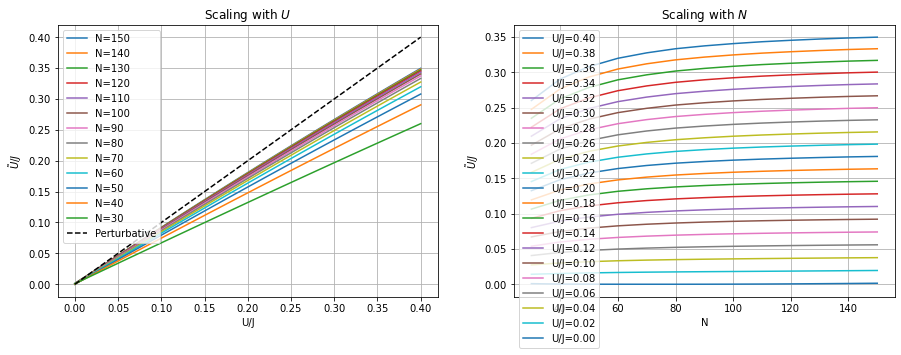

In [7]:
# reconstruct effective U
fig, ax = plt.subplots(1,2, figsize=(15,5))

min_N = 30

i_min_N = np.argmin(np.abs(v_N-min_N))

# scaling with U, different N
for i_N, N in enumerate(np.flip(list(v_N))):
    if N>=min_N:
        _=ax[0].plot(v_U/J,np.flip(dat_U, axis=0)[i_N,:]/J, label="N={}".format(N))
        
ax[0].plot([np.min(v_U)/J, np.max(v_U)/J], [np.min(v_U)/J, np.max(v_U)/J],  color='k', linestyle="--", label="Perturbative")
    
ax[0].legend(loc="upper left")
ax[0].set_xlabel("U/J")
ax[0].set_ylabel(r"$\tilde{U}/J$")
ax[0].set_title(r"Scaling with $U$")

# scaling with N, different U
for i_U, U in enumerate(list(np.flip(v_U))):
        _=ax[1].plot(v_N[i_min_N:],np.flip(dat_U,axis=1)[i_min_N:,i_U]/J, label="U/J={:.2f}".format(U/J))
    
ax[1].legend(loc="upper left")
ax[1].set_xlabel("N")
ax[1].set_ylabel(r"$\tilde{U}/J$")
ax[1].set_title(r"Scaling with $N$")

for a in ax:
    a.grid(True)

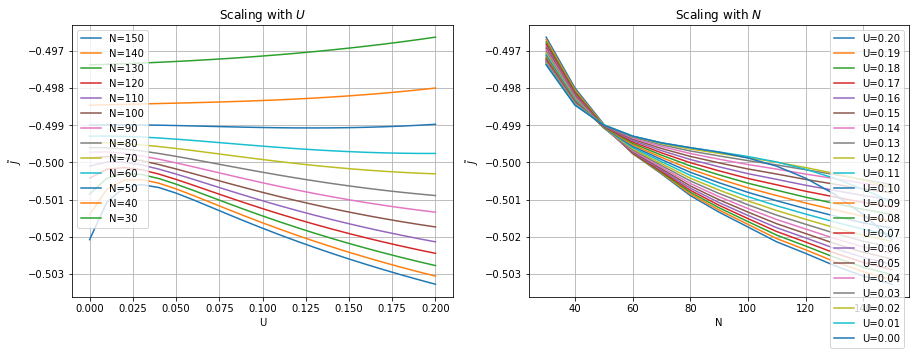

In [8]:
# reconstruct effective U
fig, ax = plt.subplots(1,2, figsize=(15,5))

min_N = 30

i_min_N = np.argmin(np.abs(v_N-min_N))

# scaling with U, different N
for i_N, N in enumerate(np.flip(list(v_N))):
    if N>=min_N:
        _=ax[0].plot(v_U,np.flip(dat_J, axis=0)[i_N,:], label="N={}".format(N))
    
ax[0].legend(loc="upper left")
ax[0].set_xlabel("U")
ax[0].set_ylabel(r"$\tilde{J}$")
ax[0].set_title(r"Scaling with $U$")

# scaling with N, different U
for i_U, U in enumerate(list(np.flip(v_U))):
        _=ax[1].plot(v_N[i_min_N:],np.flip(dat_J,axis=1)[i_min_N:,i_U], label="U={:.2f}".format(U))
    
ax[1].legend()
ax[1].set_xlabel("N")
ax[1].set_ylabel(r"$\tilde{J}$")
ax[1].set_title(r"Scaling with $N$")

for a_ in ax:
    a_.grid(True)

20


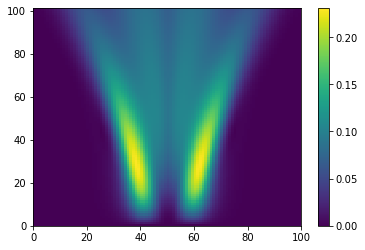

In [25]:
# reconstruct PDE and get error
N = 100
V0 = -0.3
U = 0.2
J = 0.5

i_N = np.argmin(np.abs(v_N-N))
i_U = np.argmin(np.abs(v_U-U))

descr = ['u_xx-u_yy','nx*u-ny*u']
coefs = np.array([1j*dat_J[i_N,i_U], 1j*dat_U[i_N,i_U]])

filename = folder + "/data_N_{}_V0_{:.2f}_U_{:.2f}_J_{:.2f}_T_{:.2f}.pkl".format(N, V0, U, J, N/2.)
u, t = get_data(filename)
u0 = u[0,:,:]
nskip = 10

u_test = scalar_pde_solver(descr, coefs, u0, t, dx=1, Q=None, v0=None, dirichlet_bc=None, bc="open", nskip=nskip)

plt.pcolormesh(np.abs(u_test[:,:,N//2]-u[:,:,N//2]))
plt.colorbar()
print(i_U)

In [9]:
def reconstruct_timeline(coefs, u0, t, descr=['u_xx-u_yy','nx*u-ny*u'], nskip=10):
    return scalar_pde_solver(descr, coefs, u0, t, dx=1, Q=None, v0=None, dirichlet_bc=None, bc="open", nskip=nskip)

In [24]:
v_U[20]

0.2